In [1]:
%%capture
!pip install git+https://github.com/qubvel/efficientnet

In [2]:
import math, re, os
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from efficientnet.tfkeras import EfficientNetB7 as EB7Net
import numpy as np
import pandas as pd 
AUTO = tf.data.experimental.AUTOTUNE

# TPU Connection

In [3]:
try: 
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print("Replicas: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Replicas:  8


# Initializations

In [4]:
IMAGE_SIZE = [512,512]
GCS_PATH =  KaggleDatasets().get_gcs_path()
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64),
}
UNLABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "id": tf.io.FixedLenFeature([], tf.string),
}

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 20
OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-07, amsgrad=False,
    name='Adam'
)
LOSS = 'sparse_categorical_crossentropy'
METRICS = ['sparse_categorical_accuracy']

# Funcitons

In [5]:
def get_filenames ( dataFor ):
  dataPath = GCS_PATH + '/tfrecords-jpeg-'+str(IMAGE_SIZE[0])+'x'+str(IMAGE_SIZE[1])
  return tf.io.gfile.glob(dataPath+'/'+dataFor+'/*.tfrec')

TRAIN_FILENAMES = get_filenames('train')
VAL_FILENAMES = get_filenames('val')
TEST_FILENAMES = get_filenames('test')

def decode_image(img_data):
  image = tf.image.decode_jpeg(img_data, channels=3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return tf.image.random_flip_left_right(image)

def read_labeled_tfrecord( example ):
  example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
  image = decode_image(example['image'])
  label = tf.cast(example['class'], tf.int32)
  return image, label

def read_unlabeled_tfrecord( example ):
  example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
  image = decode_image(example['image'])
  return image, example['id']

def get_data(filenames, labeled=True,ordered=False):
  options = tf.data.Options()
  if not ordered:
    options.experimental_deterministic = False
  data = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO).with_options(options)
  return data.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, 
                    num_parallel_calls=AUTO)


def get_datasets ( ):
  train = get_data(TRAIN_FILENAMES)
  train = train.repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
  test = get_data(TEST_FILENAMES, False,True)
  test = test.batch(BATCH_SIZE).prefetch(AUTO)
  val = get_data(VAL_FILENAMES)
  val = val.batch(BATCH_SIZE).cache().prefetch(AUTO)
  return train, val, test

def count_images(filenames):
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)


In [6]:
def lr(epoch):
    init_lr = 0.001
    drop = 0.5
    epoch_interval = 4
    return init_lr * math.pow(drop, math.floor((1+epoch)/epoch_interval))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr, verbose=True)

# Loading Model and Training

In [7]:
with strategy.scope():
  efficientNetModel = EB7Net(weights="imagenet", include_top=False, input_shape=[*IMAGE_SIZE, 3])
  efficientNetModel.trainable = True
  model = tf.keras.Sequential([
                               efficientNetModel,
                               tf.keras.layers.GlobalAveragePooling2D(),
                               tf.keras.layers.Dense(104, activation='softmax')
  ])

model.compile(
    optimizer = OPTIMIZER,
    loss = LOSS,
    metrics = METRICS
)

model.summary()

258441216/258434480 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [8]:
train_data, val_data, test_data = get_datasets()
STEPS = count_images(TRAIN_FILENAMES) // BATCH_SIZE
h = model.fit(train_data, steps_per_epoch=STEPS, epochs=EPOCHS, validation_data=val_data, callbacks=[lr_schedule])

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
99/99 [==============================] - 423s 4s/step - loss: 1.5580 - sparse_categorical_accuracy: 0.6301 - val_loss: 2.7524 - val_sparse_categorical_accuracy: 0.6530

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
99/99 [==============================] - 100s 1s/step - loss: 0.5097 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.5982 - val_sparse_categorical_accuracy: 0.8664

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
99/99 [==============================] - 100s 1s/step - loss: 0.3056 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.3939 - val_sparse_categorical_accuracy: 0.8944

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 4/20
99/99 [==============================] - 100s 1s/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.2517 - val_sparse_categorical_accur

# Plots

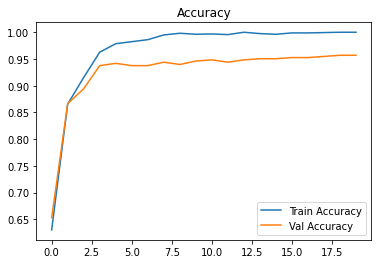

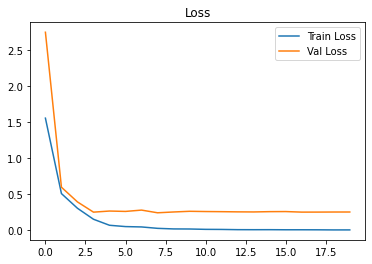

In [9]:
plt.figure(0)
plt.plot(h.history['sparse_categorical_accuracy'], label="Train Accuracy")
plt.plot(h.history['val_sparse_categorical_accuracy'], label="Val Accuracy")
plt.title("Accuracy")
plt.legend()
plt.figure(1)
plt.plot(h.history['loss'], label="Train Loss")
plt.plot(h.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Prediction

In [10]:
test_images = test_data.map(lambda image, idnum: image)
prob = model.predict(test_images)
pred = np.argmax(prob, axis=-1)
test_ids_ds = test_data.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(count_images(TEST_FILENAMES)))).numpy().astype('U')
test_pred = pd.DataFrame(np.column_stack((test_ids,pred)),columns=['id','label'])
test_pred.to_csv('submission.csv',index=False)